<a href="https://colab.research.google.com/github/somesh1237/Somesh_Nagar_21070521080_GenAI/blob/main/PBL2_Diabetic_Retinopathy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import display
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

import os
import pandas as pd
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
import random, os
import seaborn as sns
import shutil
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import sys
from tensorflow import keras, lite
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from time import perf_counter

init_notebook_mode(connected=True)

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/GAUSSIANFILTERED224X224/train.csv')

In [ ]:
# assing numerical values to the diabetic retinopathy stages and binary type
diagnosis_binary = {
    0 : 'No_DR',
    1 : 'DR',
    2 : 'DR',
    3 : 'DR',
    4 : 'DR'
}

diagnosis_stages = {
    0 : 'No_DR',
    1 : 'Mild',
    2 : 'Moderate',
    3 : 'Severe',
    4 : 'Proliferate_DR'
}

# Assinging the Diabetic Retinopathy stages and binary type to their id code and diagnosis number
df['binary_type'] = df['diagnosis'].map(diagnosis_binary.get)
df['stages'] = df['diagnosis'].map(diagnosis_stages.get)
df.head()

,id_code,diagnosis,binary_type,stages
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
# Method to display 2 interactive plots together horizontally
def two_subplots(plot1, plot2, title1, title2, w, h):
  figures = [plot1, plot2]
  fig = make_subplots(rows = 1, cols = len(figures), subplot_titles = (title1, title2))

  for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
      fig.append_trace(figure["data"][trace], row=1, col=i+1)

  fig.update_layout(width=w, height=h)

  return fig

In [ ]:
# splitting the dataset into training, testing and validation dataset
train_temp, val = train_test_split(df, test_size = 0.15, stratify = df['stages'], random_state = 1)
train, test = train_test_split(train_temp, test_size = 0.15 / (1 - 0.15), stratify = train_temp['stages'], random_state = 1)

print(train['stages'].value_counts(), '\n')
print(val['stages'].value_counts(), '\n')
print(test['stages'].value_counts(), '\n')

stages
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

stages
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

stages
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [ ]:
# Create working directories for the train, validation and test sets
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

if os.path.exists(base_dir) :
    shutil.rmtree(base_dir)

if os.path.exists(train_dir) :
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir) :
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir) :
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [ ]:
# Copying images to their respective directories

source_dir = r'/content/drive/MyDrive/GAUSSIANFILTERED224X224/gaussian_filtered_images/gaussian_filtered_images'

for i, row in train.iterrows() :
    srcfile = os.path.join(source_dir, row['stages'], (row['id_code'] + ".png"))
    dstfile = os.path.join(train_dir, row['binary_type'])
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for i, row in val.iterrows() :
    srcfile = os.path.join(source_dir, row['stages'], (row['id_code'] + ".png"))
    dstfile = os.path.join(val_dir, row['binary_type'])
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for i, row in test.iterrows() :
    srcfile = os.path.join(source_dir, row['stages'], (row['id_code'] + ".png"))
    dstfile = os.path.join(test_dir, row['binary_type'])
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

image_dir = Path('/content/drive/MyDrive/GAUSSIANFILTERED224X224/gaussian_filtered_images/gaussian_filtered_images')
filepath = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

In [ ]:
# Setting up ImageDataGenerator for train, validation, and test sets
train_batch = ImageDataGenerator(rescale = 1. / 255).flow_from_directory('train', target_size = (224, 224), shuffle = True)
val_batch = ImageDataGenerator(rescale = 1. / 255).flow_from_directory('val', target_size = (224, 224), shuffle = True)
test_batch = ImageDataGenerator(rescale = 1. / 255).flow_from_directory('test', target_size = (224, 224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


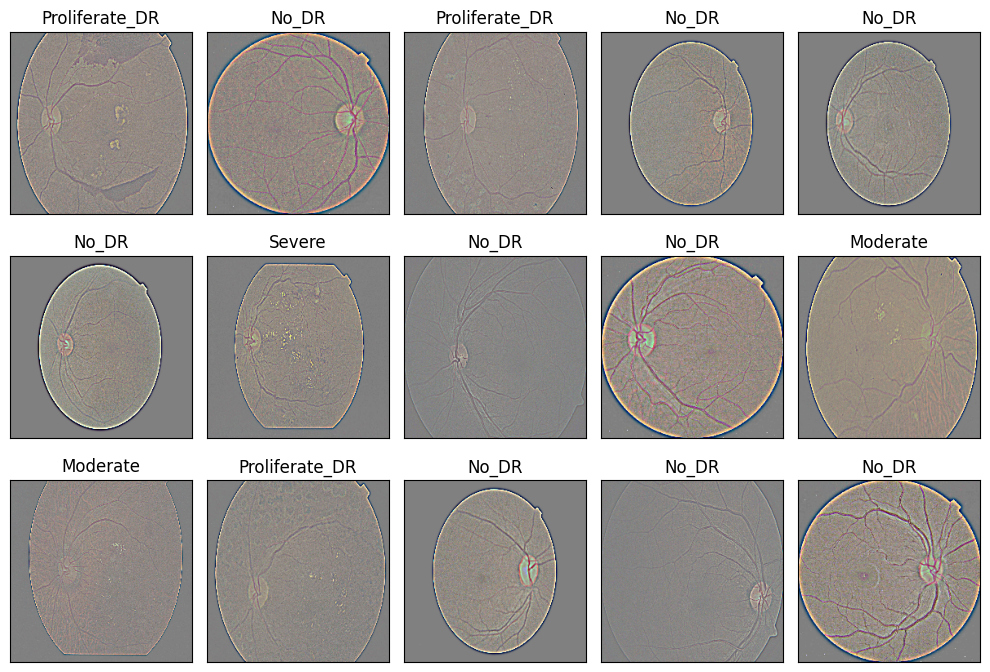

In [ ]:
# Display Diabetic Retinopathy images with its actual stage diagnosis
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (10, 7), subplot_kw = {'xticks' : [], 'yticks' : []})

filepath = pd.Series(filepath, name = 'Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')
image_df = pd.concat([filepath, labels], axis = 1)
image_df = image_df.sample(frac = 1).reset_index(drop = True)

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(image_df.Filepath[i]))
  ax.set_title(image_df.Label[i])

plt.tight_layout()
plt.style.use('dark_background')
plt.show()

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetLarge": {"model":tf.keras.applications.NASNetLarge, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [ ]:
# function to load, compile and return keras pretrained models

def get_model(model):
  kwargs = {'input_shape' : (224,224,3), 'include_top' : False, 'weights' : 'imagenet', 'pooling' : 'avg'}
  pretrained_model = model(**kwargs)
  pretrained_model.trainable = False

  inputs = pretrained_model.input

  x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)
  x = tf.keras.layers.Dense(128, activation = 'relu')(x)

  outputs = tf.keras.layers.Dense(2, activation = 'softmax')(x)
  model = tf.keras.Model(inputs = inputs, outputs = outputs)

  # Compile the model
  model.compile(
      optimizer = 'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  return model

In [ ]:
for name, model in models.items():
  m = get_model(model['model'])
  models[name]['model'] = m

  start = perf_counter()

  history = m.fit(train_batch, validation_data = val_batch, epochs = 1, verbose = 1)

  duration = perf_counter() - start
  duration = round(duration, 2)
  models[name]['perf'] = duration
  print(f"{name:10} trained in {duration} sec")

  val_acc = history.history['val_accuracy']
  models[name]['val_acc'] = [round(v, 4) for v in val_acc]

  train_acc = history.history['accuracy']
  models[name]['train_accuracy'] = [round(v, 4) for v in train_acc]

81/81 [==============================] - 65s 733ms/step - loss: 0.2106 - accuracy: 0.9301 - val_loss: 0.1913 - val_accuracy: 0.9455
DenseNet121 trained in 65.47 sec
81/81 [==============================] - 79s 871ms/step - loss: 0.2287 - accuracy: 0.9133 - val_loss: 0.1221 - val_accuracy: 0.9618
DenseNet169 trained in 79.07 sec
81/81 [==============================] - 101s 1s/step - loss: 0.1989 - accuracy: 0.9286 - val_loss: 0.1188 - val_accuracy: 0.9636
DenseNet201 trained in 101.02 sec
81/81 [==============================] - 38s 389ms/step - loss: 0.7002 - accuracy: 0.5109 - val_loss: 0.6928 - val_accuracy: 0.5073
EfficientNetB0 trained in 37.75 sec
81/81 [==============================] - 53s 533ms/step - loss: 0.6876 - accuracy: 0.5476 - val_loss: 0.6510 - val_accuracy: 0.4927
EfficientNetB1 trained in 52.79 sec
81/81 [==============================] - 54s 563ms/step - loss: 0.6987 - accuracy: 0.5055 - val_loss: 0.7239 - val_accuracy: 0.5073
EfficientNetB2 trained in 54.5 sec
81/

In [ ]:
models_result = []

for name, v in models.items():
  models_result.append([name, models[name]['train_accuracy'][-1], models[name]['val_acc'][-1], models[name]['perf']])

df_results = pd.DataFrame(models_result, columns = ['Model', 'Train Accuracy', 'Validation Accuracy', 'Training Time (Sec)'])
df_results.sort_values(by = 'Validation Accuracy', ascending = False, inplace = True)
df_results.reset_index(inplace = True, drop = True)
df_results.head(28)

,Model,Train Accuracy,Validation Accuracy,Training Time (Sec)
0,ResNet152V2,0.9415,0.9727,93.65
1,MobileNet,0.9040,0.9691,17.11
2,DenseNet201,0.9286,0.9636,101.02
3,ResNet50V2,0.9305,0.9636,42.04
4,MobileNetV2,0.9282,0.9618,21.95
5,DenseNet169,0.9133,0.9618,79.07
6,NASNetLarge,0.9149,0.9600,128.34
7,InceptionResNetV2,0.8813,0.9564,63.20
8,NASNetMobile,0.9016,0.9545,34.32
9,Xception,0.9200,0.9527,46.18


In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding = 'valid', input_shape = (224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2,  activation = 'softmax')
])

model.compile(optimizer=Adam(lr = 1e-4), loss = 'BinaryCrossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_304 (Conv2D)         (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 8)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_304 (B  (None, 111, 111, 8)       32        
 atchNormalization)                                              
                                                                 
 conv2d_305 (Conv2D)         (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 54, 54, 16)        0         
 ng2D)                                                           
                                                      

In [ ]:
!pip install pydot
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 807.8 kB/s eta 0:00:00


In [ ]:
plot_model(model, show_dtype=True, show_layer_names = True, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# train the model
history = model.fit(train_batch, epochs = 10, validation_data = val_batch)

Epoch 1/10
81/81 [==============================] - 12s 126ms/step - loss: 0.4347 - acc: 0.8794 - val_loss: 0.9662 - val_acc: 0.5073
Epoch 2/10
81/81 [==============================] - 10s 121ms/step - loss: 0.2375 - acc: 0.9161 - val_loss: 0.6409 - val_acc: 0.6091
Epoch 3/10
81/81 [==============================] - 10s 124ms/step - loss: 0.1826 - acc: 0.9430 - val_loss: 0.4807 - val_acc: 0.7818
Epoch 4/10
81/81 [==============================] - 10s 124ms/step - loss: 0.1211 - acc: 0.9559 - val_loss: 0.7664 - val_acc: 0.6291
Epoch 5/10
81/81 [==============================] - 10s 125ms/step - loss: 0.0742 - acc: 0.9731 - val_loss: 0.2198 - val_acc: 0.9309
Epoch 6/10
81/81 [==============================] - 10s 124ms/step - loss: 0.0537 - acc: 0.9762 - val_loss: 0.3533 - val_acc: 0.8291
Epoch 7/10
81/81 [==============================] - 10s 124ms/step - loss: 0.0288 - acc: 0.9883 - val_loss: 0.2412 - val_acc: 0.9182
Epoch 8/10
81/81 [==============================] - 10s 123ms/step - 

In [ ]:
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epoch = [i + 1 for i in range(len(train_acc))]

# creating a dataframe consisting the train / validation loss and accuracy of each epoch along with its corresponding epoch
acc_loss_df = pd.DataFrame({'Train Accuracy' : train_acc, 'Train Loss' : train_loss, 'Validation Accuracy' : val_acc, 'Validation Loss' : val_loss, 'Epoch' : epoch})

acc_loss_df.head(10)

,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Epoch
0,0.879391,0.434659,0.507273,0.966222,1
1,0.916081,0.237464,0.609091,0.640942,2
2,0.943013,0.182588,0.781818,0.480655,3
3,0.955894,0.121052,0.629091,0.766443,4
4,0.973068,0.074190,0.930909,0.219791,5
5,0.976190,0.053679,0.829091,0.353253,6
6,0.988290,0.028823,0.918182,0.241184,7
7,0.990242,0.025531,0.872727,0.612172,8
8,0.994145,0.022901,0.947273,0.220423,9
9,0.995316,0.014219,0.927273,0.312248,10


In [ ]:
loss, acc = model.evaluate(test_batch, verbose = 1)

print('Classification Accuracy :','{0:.4}'.format(acc))
print('Classification Loss: ','{0:.4}'.format(loss))

18/18 [==============================] - 1s 71ms/step - loss: 0.4065 - acc: 0.9055
Classification Accuracy : 0.9055
Classification Loss:  0.4065


In [ ]:
pred = model.predict(test_batch)
y_pred = np.argmax(pred, axis = 1)

18/18 [==============================] - 1s 72ms/step


In [ ]:
model.save("MobileNet")

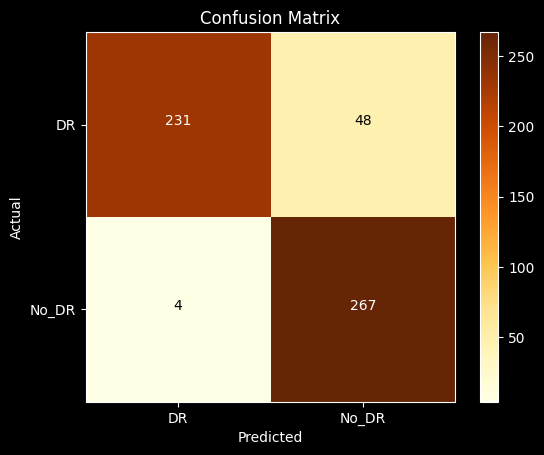

In [ ]:
g_dict = test_batch.class_indices
classes = list(g_dict.keys())

# Confusion Matrix
cm = confusion_matrix(test_batch.classes, y_pred)

plt.imshow(cm, interpolation = 'nearest', cmap = 'YlOrBr')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


In [ ]:
print(classification_report(test_batch.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

          DR       0.98      0.83      0.90       279
       No_DR       0.85      0.99      0.91       271

    accuracy                           0.91       550
   macro avg       0.92      0.91      0.91       550
weighted avg       0.92      0.91      0.90       550



In [ ]:
import cv2
def predict_class(path):
  img = cv2.imread(path)
  final_img = cv2.resize(img, (224, 224))
  plt.imshow(img)
  image = np.array(final_img) / 255.0
  final_model = tf.keras.models.load_model("MobileNet")
  predict = final_model.predict(np.array([image]))
  per = np.argmax(predict, axis = 1)
  if per == 1:
    print("No DR Detected")
  else:
    print("DR Detected")

1/1 [==============================] - 0s 104ms/step
DR Detected


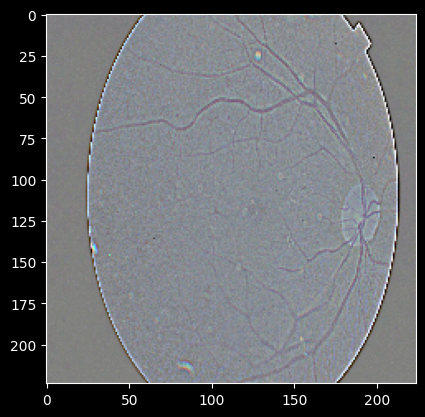

In [ ]:
predict_class('/content/test/DR/1ee1eb7943db.png')